In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

import os
import random
import numpy as np
import math
from datetime import datetime

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torchvision.transforms as transforms

from lib.datasets.an4 import create_manifest, create_pseudo_manifest
from lib.vocabulary import Vocabulary
from lib.dataloader.audio import AudioDataset, BucketingSampler, collate_fn, DummyDataset, dummy_collate_fn
from lib.transforms.general import FromNumpyToTensor, TranscriptEncodeCTC
from lib.transforms.audio import AudioSpectrogram, AudioNoiseInjection, AudioNoiseGeneration, \
                                 AudioNormalizeDB, AudioNormalize, AudioPitchShift, AudioTimeStrech, \
                                 AudioDynamicRange, AudioTimeShift, AudioNoiseGeneration, AudioAugmentation
from lib.models.deepspeech2 import DeepSpeech2
from lib.trainer import Trainer
from lib.evaluator import Evaluator
from lib.recognizer import Recognizer
from lib.scorer import Scorer
from lib.decoder import CTCGreedyDecoder, CTCBeamSearchDecoder
from lib.loss import PytorchCTCLoss
from lib.trainlogger import *
from lib.stopping import *
from lib.checkpoint import *
from lib.utilities import *
from lib.tools import *


%load_ext watermark
%watermark -a "tb" -d -v -m -p sys,numpy,pandas,sklearn,torch,IPython
gpu_stat()

tb 2019-02-03 

CPython 3.6.4
IPython 6.2.1

sys 3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 12:04:33) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy 1.14.2
pandas 0.22.0
sklearn 0.19.2
torch 1.0.0a0+1e45e7a
IPython 6.2.1

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.5.0
machine    : x86_64
processor  : i386
CPU cores  : 24
interpreter: 64bit
GPU Name: TITAN Xp
GPU Memory: 12.0GB
CUDA Version: (9, 1, 0)
GPU Free/Total Memory: 98%


In [2]:
H = HYPERPARAMETERS({
    'EXPERIMENT'                    : 'AN4',
    'DESCRIPTION'                   : 'Deepspeech2 model ',
    'TIMESTAMP'                     : HYPERPARAMETERS.create_timestamp() ,
    
    'MODEL_NAME'                    : 'AN4_CTC_deepspeech2_with_augmentation',
    
    'PRELOAD_MODEL_PATH'            : 'AN4_CTC_deepspeech2_no_augmentation.tar',
    
    'ROOT_DIR'                      : 'data',
    'MANIFESTS'                     : ['manifest.json'], #, 'manifest_pseudo.json'],

    'BATCH_SIZE'                    : 20,
    'NUM_WORKERS'                   : 4,
        
    'RNN_HIDDEN_SIZE'               : 800,
    'NUM_LAYERS'                    : 5,
    'RNN_DROPOUT'                   : 0.5,
    'CNN_DROPOUT'                   : 0.5,
    'BIDIRECTIONAL'                 : True ,

    'LR'                            : 0.0006,
    'LR_LAMBDA'                     : lambda epoch: max(math.pow(0.78, math.floor((1 + epoch) / 200.0)), 0.01), 
    'WEIGHT_DECAY'                  : 0, 
    'MOMENTUM'                      : 0.9 ,
    'NESTEROV'                      : True ,
    
    'MAX_GRAD_NORM'                 : 400,
    
    'NUM_EPOCHS'                    : 200,
    
    'STOPPING_PATIENCE'             : 80,
    
    'CHECKPOINT_INTERVAL'           : 140 ,
    'CHECKPOINT_RESTORE'            : False ,
    
    'USE_CUDA'                      : torch.cuda.is_available(),
        
    'SEED'                          : 123456,

    'DATASET_MEAN_STD'              : (0.060487103, 0.16884679),

    'NORMALIZE_DB'                  : -40,
    'NORMALIZE_MAX_GAIN'            : 300,

    'MIN_MAX_AUDIO_DURATION'        : None, # (1, 15),
    'MIN_MAX_TRANSCRIPT_LEN'        : None, # (3, 60),
    'MIN_TRANSCRIPT_CONFIDENCE'     : None, # 0.92,
    
    'AUDIO_SAMPLE_RATE'             : 16000,

    'SPECT_WINDOW_SIZE'             : 0.02,
    'SPECT_WINDOW_STRIDE'           : 0.01,
    'SPECT_WINDOW'                  : 'hamming',
    
    'AUGMENTATION_PROBABILITY'      : 0.6,

    'NOISE_BG_PROBABILITY'          : 0.4,
    'NOISE_BG_LEVELS'               : (0.0, 0.5),
    'NOISE_BG_DIR'                  : '/Volumes/SSD1/BACKGROUND_NOISE',
  
    'AUDIO_PITCH_PROBABILITY'       : 0.4,
    'AUDIO_PITCH_PM'                : 4,     
    
    'AUDIO_SPEED_PROBABILITY'       : 0.4,
    'AUDIO_SPEED_LOW_HIGH'          : (0.9, 1.1),    
    
    'AUDIO_DYNAMIC_PROBABILITY'     : 0.4,
    'AUDIO_DYNAMIC_LOW_HIGH'        : (0.5, 1.1),    
    
    'AUDIO_SHIFT_PROBABILITY'       : 0.4,
    'AUDIO_SHIFT_MIN_MAX'           : (-5, 5),    
    
    'AUDIO_NOISE_PROBABILITY'       : 0.4,
    'AUDIO_NOISE_LEVELS'            : (0.0, 0.5),
    'AUDIO_NOISE_COLORS'            : ['white', 'pink', 'blue', 'brown', 'violet'],
})

if not os.path.exists(H.EXPERIMENT):
        os.makedirs(H.EXPERIMENT)      
H.pprint(os.path.join(H.EXPERIMENT, H.MODEL_NAME + ".txt"))

In [3]:
#torch.cuda.is_available = lambda : False
#torch.backends.cudnn.enabled=False
torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = True

random.seed(H.SEED)
np.random.seed(H.SEED)
torch.manual_seed(H.SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(H.SEED)
    torch.cuda.manual_seed_all(H.SEED)

In [4]:
import librosa.display

def plot_wave(data, sr):
    plt.figure(figsize=(14, 5))
    plt.title('Time Domain (raw)')
    plt.ylabel('Amplitude')

    librosa.display.waveplot(data, sr=sr);

def load_transcript(path):
    with open(path, 'r', encoding='utf8') as f:
        transcript = f.read().strip()
    return transcript

def load_audio(path, sr):
        from scipy.io import wavfile
        fs, data = wavfile.read(path)

        assert fs == sr, "File sampling rate doesn't match manifest."
        assert data.dtype.name == 'int16', "Required by normalization"
        assert len(data.shape) == 1, "multiple channels wav files not supported"

        data = np.asarray(data, dtype='float32') / np.iinfo(np.dtype('int16')).min  # normalization

        return data

In [5]:
AudioNoiseInjection.create_manifest(H.NOISE_BG_DIR, sr=H.AUDIO_SAMPLE_RATE, verbose=1)

In [6]:
create_manifest(root_path='./data/AN4',
                manifest_file='manifest.json',
                url='http://www.speech.cs.cmu.edu/databases/an4/an4_raw.bigendian.tar.gz',
                verbose=1)

In [7]:
transform = transforms.Compose([
    AudioSpectrogram(sample_rate=H.AUDIO_SAMPLE_RATE, window_size=H.SPECT_WINDOW_SIZE, 
                     window_stride=H.SPECT_WINDOW_STRIDE, window=H.SPECT_WINDOW),
])

dataset = AudioDataset(os.path.join(H.ROOT_DIR, H.EXPERIMENT), manifests_files=H.MANIFESTS, datasets=["train", "test"])

In [8]:
_mean, _std = AudioNormalize.compute_mean_std(dataset, transform, datasets=["test"], samples=None)

_mean, _std

(0.060487103, 0.16884679)

In [9]:
min_rms, max_rms, mean_rms = AudioNormalizeDB.compute_rms_db(dataset, datasets=['train'], samples=None)

min_rms, max_rms, mean_rms

(-47.66678810119629, -22.44837999343872, -30.84806500607905)

In [10]:
# vocab = Vocabulary(os.path.join(H.ROOT_DIR, H.EXPERIMENT), encoding="ctc")

# vocab.create("_'ABCDEFGHIJKLMNOPQRSTUVWXYZ ")
# vocab.dump()

In [11]:
vocab = Vocabulary(os.path.join(H.ROOT_DIR, H.EXPERIMENT), encoding="ctc")

print('->'+str(vocab)+'<-', len(vocab))

->_'ABCDEFGHIJKLMNOPQRSTUVWXYZ <- 29


In [12]:
audio_transform_train = transforms.Compose([
#                 AudioNoiseInjection( probability=H.NOISE_BG_PROBABILITY, 
#                                      noise_levels=H.NOISE_BG_LEVELS, 
#                                      noise_dir=H.NOISE_BG_DIR),
#                 AudioPitchShift( probability=H.AUDIO_PITCH_PROBABILITY,
#                                  sample_rate=H.AUDIO_SAMPLE_RATE,
#                                  pitch_pm=H.AUDIO_PITCH_PM),
#                 AudioTimeStrech( probability=H.AUDIO_SPEED_PROBABILITY,
#                                  low_high=H.AUDIO_SPEED_LOW_HIGH),
#                 AudioDynamicRange( probability=H.AUDIO_DYNAMIC_PROBABILITY,
#                                    low_high=H.AUDIO_DYNAMIC_LOW_HIGH),
#                 AudioShiftTime( probability=H.AUDIO_SHIFT_PROBABILITY,
#                                 percent=H.AUDIO_SHIFT_PERCENT),
#                 AudioNoiseGeneration( probability=H.AUDIO_NOISE_PROBABILITY,
#                                       noise_levels=H.AUDIO_NOISE_LEVELS,
#                                       noise_colors=H.AUDIO_NOISE_COLORS),
#                 AudioNormalizeDB(db=H.NORMALIZE_DB, 
#                                  max_gain_db=H.NORMALIZE_MAX_GAIN),
                AudioSpectrogram(sample_rate=H.AUDIO_SAMPLE_RATE, 
                                 window_size=H.SPECT_WINDOW_SIZE, 
                                 window_stride=H.SPECT_WINDOW_STRIDE, 
                                 window=H.SPECT_WINDOW),
                AudioNormalize(),
                FromNumpyToTensor(tensor_type=torch.FloatTensor)
                ])

audio_transform = transforms.Compose([
                AudioNormalizeDB(db=H.NORMALIZE_DB, 
                                 max_gain_db=H.NORMALIZE_MAX_GAIN),
                AudioSpectrogram(sample_rate=H.AUDIO_SAMPLE_RATE, 
                                 window_size=H.SPECT_WINDOW_SIZE, 
                                 window_stride=H.SPECT_WINDOW_STRIDE,
                                 window=H.SPECT_WINDOW),
                AudioNormalize(),
                FromNumpyToTensor(tensor_type=torch.FloatTensor)
                ])

label_transform = transforms.Compose([
                TranscriptEncodeCTC(vocab),
                FromNumpyToTensor(tensor_type=torch.LongTensor)
                ])

In [13]:
train_dataset = AudioDataset(os.path.join(H.ROOT_DIR, H.EXPERIMENT), 
                             manifests_files=H.MANIFESTS, 
                             datasets="train", 
                             transform=audio_transform_train, 
                             label_transform=label_transform, 
                             max_data_size=None, 
                             sorted_by='recording_duration',
                             min_max_duration=H.MIN_MAX_AUDIO_DURATION, 
                             min_max_length=H.MIN_MAX_TRANSCRIPT_LEN, 
                             min_confidence=H.MIN_TRANSCRIPT_CONFIDENCE)

train_sampler = BucketingSampler(train_dataset, batch_size=H.BATCH_SIZE)
train_loader = torch.utils.data.DataLoader( 
    train_dataset, num_workers=H.NUM_WORKERS, batch_sampler=train_sampler, collate_fn=collate_fn, pin_memory=True)

train_dataset, len(train_loader)

(AudioDataset
     Total of datapoints: 948
     Total of duration (min): 42.438333333333425
     Root Location: data/AN4
     Transforms: 
         AudioSpectrogram(sample_rate=16000, window_size=0.02, window_stride=0.01, window=hamming)
         AudioNormalize(mean=None, std=None)
         FromNumpyToTensor(tensor_type=FloatTensor)
     Label Transforms: 
         TranscriptEncodeCTC(vocab=_'ABCDEFGHIJKLMNOPQRSTUVWXYZ )
         FromNumpyToTensor(tensor_type=LongTensor), 48)

In [14]:
%time
for idx, (input_vars, label_vars, input_sizes_cpu, label_sizes_cpu, indexes) in enumerate(train_loader):
    input_vars_cpu = input_vars.cpu()
    label_vars_cpu = label_vars.cpu()
    break

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 22.9 µs


In [15]:
''.join([vocab(t.item()) for t in label_vars_cpu[0]])

'NO____'

In [16]:
load_transcript(train_dataset.manifest[indexes[0]]['transcript_path'])

'NO'

In [17]:
sr = H.AUDIO_SAMPLE_RATE
data = load_audio(train_dataset.manifest[indexes[0]]['recording_path'], sr)

<class 'numpy.ndarray'> (12800,) 12800 16000


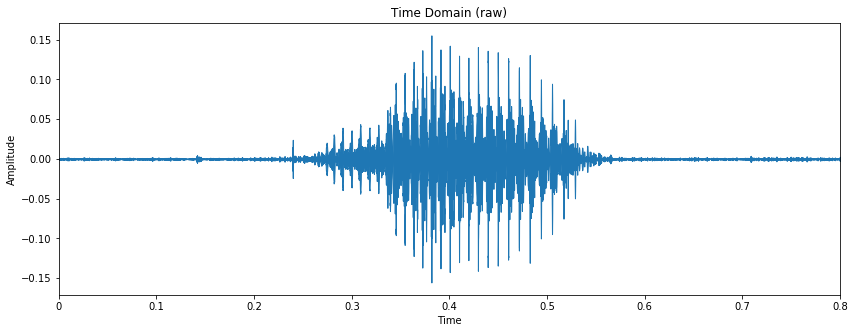

In [18]:
from scipy.io import wavfile

plot_wave(data, sr)

print(type(data), data.shape, len(data), sr)

import IPython.display as ipd
ipd.Audio(data, rate=sr);

In [19]:
durations = sorted([entry['recording_duration'] for entry in train_dataset.manifest], reverse=True)

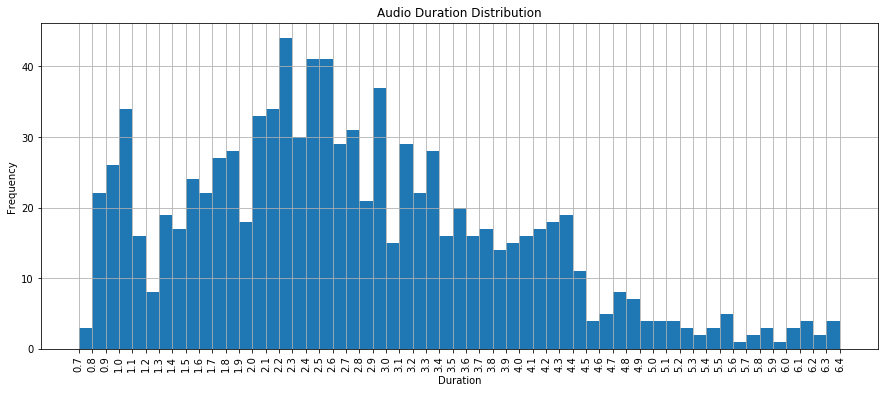

In [20]:
import math

binwidth = 0.1
bins = np.arange(min(durations), max(durations) + binwidth, binwidth)

fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_xticks(bins)


ax = plt.hist(durations, bins=bins)


plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.title("Audio Duration Distribution")
plt.xticks(rotation=90)
plt.grid(True);

In [21]:
lengths = sorted([entry['transcript_length'] for entry in train_dataset.manifest], reverse=True)

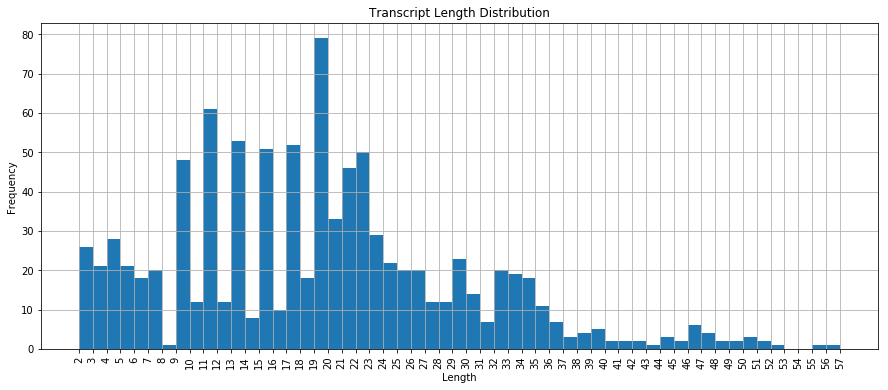

In [22]:
import math

binwidth = 1
bins = np.arange(min(lengths), max(lengths) + binwidth, binwidth)

fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_xticks(bins)

ax = plt.hist(lengths, bins=bins)

plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title("Transcript Length Distribution")
plt.xticks(rotation=90)
plt.grid(True);

In [23]:
confidence = sorted([entry['transcript_confidence'] for entry in train_dataset.manifest], reverse=True)

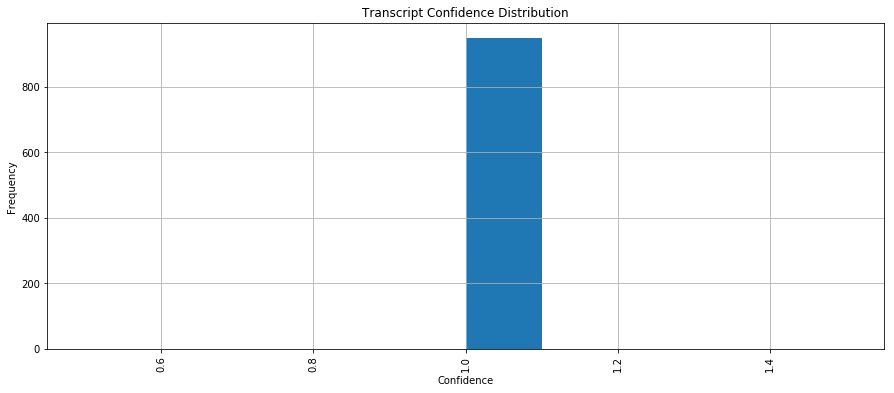

In [24]:
import math

fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 1, 1)

ax = plt.hist(confidence)

plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.title("Transcript Confidence Distribution")
plt.xticks(rotation=90)
plt.grid(True);

In [25]:
1/0

ZeroDivisionError: division by zero

In [ ]:
model_pred = DeepSpeech2(len(vocab), rnn_hidden_size=H.RNN_HIDDEN_SIZE, nb_layers=H.NUM_LAYERS, 
                         bidirectional=H.BIDIRECTIONAL, cnn_dropout=H.CNN_DROPOUT, rnn_dropout=H.RNN_DROPOUT, 
                         sample_rate=H.AUDIO_SAMPLE_RATE, window_size=H.SPECT_WINDOW_SIZE, initialize=torch_weight_init)
if H.USE_CUDA:
    model_pred.cuda()
    
state = torch.load(os.path.join(H.EXPERIMENT, H.PRELOAD_MODEL_PATH))
model_pred.load_state_dict(state)   

ctc_decoder = CTCGreedyDecoder(vocab)
# ctc_decoder = CTCBeamSearchDecoder(vocab, lm_path=None, alpha=0, beta=0, cutoff_top_n=40, cutoff_prob=1.0, 
#                                    beam_width=40, num_processes=8, blank_index=0)


In [ ]:
audio_transform = transforms.Compose([
                AudioNormalizeDB(db=H.NORMALIZE_DB, 
                                 max_gain_db=H.NORMALIZE_MAX_GAIN),
                AudioSpectrogram(sample_rate=H.AUDIO_SAMPLE_RATE, 
                                 window_size=H.SPECT_WINDOW_SIZE, 
                                 window_stride=H.SPECT_WINDOW_STRIDE,
                                 window=H.SPECT_WINDOW),
                AudioNormalize(),
                FromNumpyToTensor(tensor_type=torch.FloatTensor)
                ])

label_transform = transforms.Compose([
                TranscriptEncodeCTC(vocab),
                FromNumpyToTensor(tensor_type=torch.IntTensor)
                ])

In [ ]:
test_dataset = AudioDataset(os.path.join(H.ROOT_DIR, H.EXPERIMENT), manifests_files=H.MANIFESTS, datasets="test",
                            transform=audio_transform, label_transform=label_transform, max_data_size=None, 
                            sorted_by='recording_duration',
                            min_max_duration=H.MIN_MAX_AUDIO_DURATION, min_max_length=H.MIN_MAX_TRANSCRIPT_LEN, 
                            min_confidence=H.MIN_TRANSCRIPT_CONFIDENCE)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=H.BATCH_SIZE, num_workers=H.NUM_WORKERS, 
                                          shuffle=False, collate_fn=collate_fn, pin_memory=True)

test_dataset, len(test_loader)

In [ ]:
from torchnlp.metrics import get_moses_multi_bleu

recognizer = Recognizer(model_pred, ctc_decoder, test_loader, probabilities=True)

hypotheses = recognizer()

transcripts = []
for _, label_vars, _, label_sizes,_ in test_loader:
    label_seq = ctc_decoder.decode_labels(label_vars, label_sizes, vocab)   
    transcripts.extend(label_seq )

In [ ]:
hypotheses[0:5]

In [ ]:
lines = 0
bad_lines = []
for dseq_probas, tseq in zip(hypotheses, transcripts):
    dseq, proba = dseq_probas
    lines += 1
    if sum([d!=t for d,t in zip (dseq, tseq)]):
        bad_lines.append((dseq, tseq, proba))

print('Test Summary \n'
      'Total Lines:   {lines:.3f}\n'
      'None Matches:  {bad_lines:.3f}\n'
      'Percent:       {acc:.3f}\n'.format(lines=lines, 
                                          bad_lines=len(bad_lines), 
                                          acc=100 -(float(len(bad_lines))/lines*100)))

In [ ]:
for b in bad_lines[0:60]:
    if b[2] > 0.95:
        print(b[0],"|", b[1].strip(), "("+ str(b[2]) +")")

In [ ]:
confidence = sorted([entry[1] for entry in hypotheses], reverse=True)

In [ ]:
import math

fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 1, 1)

ax = plt.hist(confidence)

plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.title("Transcript Confidence Distribution")
plt.xticks(rotation=90)
plt.grid(True);

In [ ]:
PRELOAD_MODEL_PATH = 'AN4_CTC_deepspeech2_no_augmentation.tar'

In [ ]:
model_pred = DeepSpeech2(len(vocab), rnn_hidden_size=H.RNN_HIDDEN_SIZE, nb_layers=H.NUM_LAYERS, 
                       bidirectional=H.BIDIRECTIONAL, cnn_dropout=H.CNN_DROPOUT, rnn_dropout=H.RNN_DROPOUT, 
                       sample_rate=H.AUDIO_SAMPLE_RATE, window_size=H.SPECT_WINDOW_SIZE, initialize=torch_weight_init)
if H.USE_CUDA:
    model_pred.cuda()
    
state = torch.load(os.path.join(H.EXPERIMENT, PRELOAD_MODEL_PATH))
model_pred.load_state_dict(state)   

ctc_decoder = CTCGreedyDecoder(vocab)
# ctc_decoder = CTCBeamSearchDecoder(vocab, lm_path=None, alpha=0, beta=0, cutoff_top_n=40, cutoff_prob=1.0, 
#                                    beam_width=40, num_processes=8, blank_index=0)


In [ ]:
test_path = './data/AN4/test/wav/*.wav'

import glob
audio_files = glob.glob(test_path)

len(audio_files)

In [ ]:
audio_transform = transforms.Compose([
                AudioNormalizeDB(db=H.NORMALIZE_DB, 
                                 max_gain_db=H.NORMALIZE_MAX_GAIN),
                AudioSpectrogram(sample_rate=H.AUDIO_SAMPLE_RATE, 
                                 window_size=H.SPECT_WINDOW_SIZE, 
                                 window_stride=H.SPECT_WINDOW_STRIDE,
                                 window=H.SPECT_WINDOW),
                AudioNormalize(),
                FromNumpyToTensor(tensor_type=torch.FloatTensor)
                ])

dummy_dataset = DummyDataset(audio_files, H.AUDIO_SAMPLE_RATE, vocab, transform=audio_transform)

dummy_loader = torch.utils.data.DataLoader(dummy_dataset, batch_size=H.BATCH_SIZE, 
                                           num_workers=H.NUM_WORKERS, shuffle=False, 
                                           collate_fn=dummy_collate_fn, pin_memory=True)

recognizer = Recognizer(model_pred, ctc_decoder, dummy_loader, probabilities=True)

hypotheses = recognizer()

In [ ]:
idxs = []
for data in dummy_loader:
    idxs.extend(data[2])    
    
audio=[]
for i in idxs:
    audio.append(dummy_dataset.audio_files[i])
      
len(hypotheses), len(audio)

In [ ]:
hypotheses[0:4]

In [ ]:
root_path = os.path.join('.', H.ROOT_DIR, H.EXPERIMENT)

create_pseudo_manifest(root_path, audio, hypotheses, manifest_file='manifest_pseudo.json')

In [ ]:
MIN_TRANSCRIPT_CONFIDENCE = 0.92

In [ ]:
pseudo_dataset = AudioDataset(os.path.join(H.ROOT_DIR, H.EXPERIMENT), 
                              manifests_files='manifest_pseudo.json', datasets="pseudo", 
                              transform=audio_transform_train, label_transform=label_transform, 
                              max_data_size=None, sorted_by='recording_duration',
                              min_confidence=MIN_TRANSCRIPT_CONFIDENCE)


pseudo_sampler = BucketingSampler(pseudo_dataset, batch_size=H.BATCH_SIZE)
pseudo_loader = torch.utils.data.DataLoader(pseudo_dataset, num_workers=H.NUM_WORKERS, 
                                            batch_sampler=pseudo_sampler, collate_fn=collate_fn, pin_memory=True)

pseudo_dataset, len(pseudo_loader)

In [ ]:
for idx, (input_vars, label_vars, input_percentages_cpu, label_sizes_cpu, indexes) in enumerate(pseudo_loader):
    input_vars_cpu = Variable(input_vars).cpu()
    label_vars_cpu = Variable(label_vars).cpu()
    break

In [ ]:
''.join([vocab(t.item()) for t in label_vars_cpu[0]])

In [ ]:
load_transcript(pseudo_dataset.manifest[indexes[0]]['transcript_path'])

In [ ]:
sr = H.AUDIO_SAMPLE_RATE
data = load_audio(pseudo_dataset.manifest[indexes[0]]['recording_path'], sr)

In [ ]:
from scipy.io import wavfile

plot_wave(data, sr)

print(type(data), data.shape, len(data), sr)

import IPython.display as ipd
ipd.Audio(data, rate=sr)

In [ ]:
confidence = sorted([entry['transcript_confidence'] for entry in pseudo_dataset.manifest], reverse=True)

In [ ]:
import math

fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 1, 1)

ax = plt.hist(confidence)

plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.title("Transcript Confidence Distribution")
plt.xticks(rotation=90)
plt.grid(True);